cell 1 buat import

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from skimage.feature import graycomatrix, graycoprops
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from collections import defaultdict
import joblib
import glob
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings

cell 2 preprocess

In [2]:
def preprocess(img, use_blur=False):  # Changed default to False
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX)
    if use_blur:
        gray = cv2.GaussianBlur(gray, (7, 7), 0)
    return gray

cell 3 grab datad data

In [3]:
image_paths = glob.glob("coba*.jpg")
if not image_paths:
    print("Tidak ditemukan file yang diawali dengan nama 'coba'.")
else:
    image_path = image_paths[0]
    img = cv2.imread(image_path)
    resized = cv2.resize(img, (200, 200))
    pass


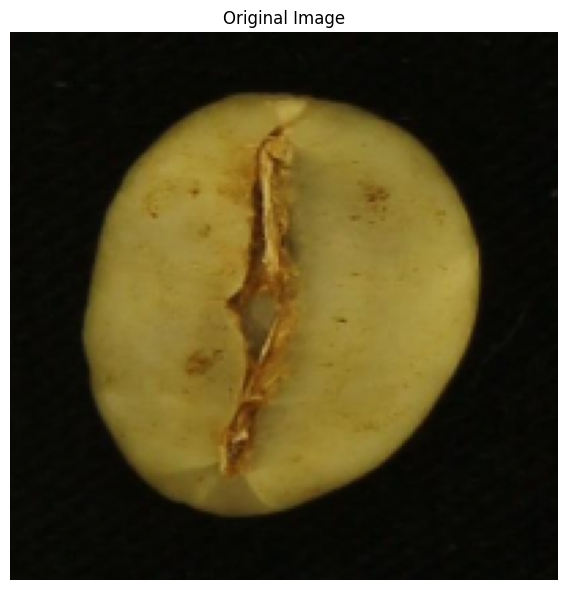

In [4]:
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")
plt.tight_layout()
plt.show()

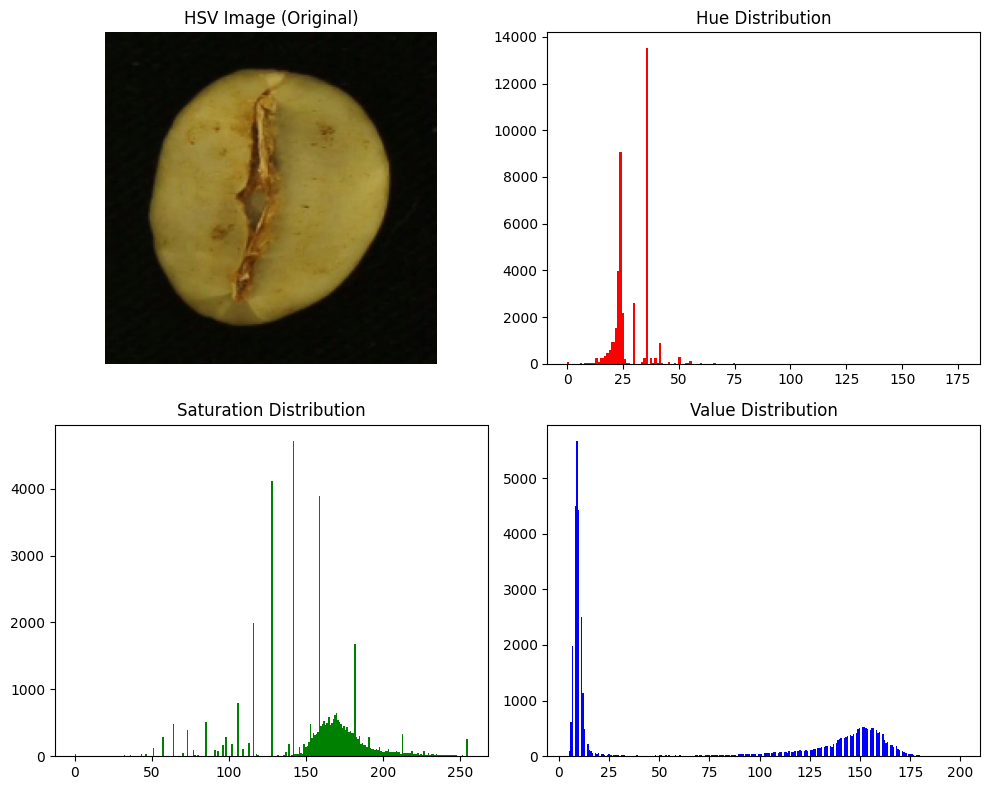

In [5]:
hsv = cv2.cvtColor(resized, cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(hsv)

fig = plt.figure(figsize=(10, 8))
ax0 = fig.add_subplot(2, 2, 1)
ax0.imshow(cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB))
ax0.set_title("HSV Image (Original)")
ax0.axis("off")

ax1 = fig.add_subplot(2, 2, 2)
ax1.hist(h.ravel(), bins=180, color='red')
ax1.set_title("Hue Distribution")

ax2 = fig.add_subplot(2, 2, 3)
ax2.hist(s.ravel(), bins=256, color='green')
ax2.set_title("Saturation Distribution")

ax3 = fig.add_subplot(2, 2, 4)
ax3.hist(v.ravel(), bins=256, color='blue')
ax3.set_title("Value Distribution")

plt.tight_layout()
plt.show()

In [6]:
def extract_features(img):
    # Hanya flatten image tanpa segmentasi, HSV, atau GLCM
    img_resized = cv2.resize(img, (64, 64))
    return img_resized.flatten()

# Training dengan dataset yang belum di-seimbangkan

Langsung lakukan training pada dataset tanpa segmentasi dan ekstraksi fitur. Dataset diambil dari folder train, valid, dan test.

Loading unbalanced datasets (tanpa segmentasi/ekstraksi)...


Robusta: 1622 samples (using all)
Arabika: 5212 samples (using all)
Liberika: 402 samples (using all)
Arabika: 662 samples (using all)
Robusta: 205 samples (using all)
Liberika: 51 samples (using all)
Arabika: 659 samples (using all)
Robusta: 208 samples (using all)
Liberika: 51 samples (using all)

Unbalanced class distribution:
Train: Counter({'Arabika': 5212, 'Robusta': 1622, 'Liberika': 402})
Valid: Counter({'Arabika': 662, 'Robusta': 205, 'Liberika': 51})
Test: Counter({'Arabika': 659, 'Robusta': 208, 'Liberika': 51})

Unbalanced dataset shapes:
Train: (7236, 12288)
Valid: (918, 12288)
Test: (918, 12288)

Training set distribution:
Robusta: 1622 samples (22.4%)
Arabika: 5212 samples (72.0%)
Liberika: 402 samples (5.6%)

Validation set distribution:
Arabika: 662 samples (72.1%)
Robusta: 205 samples (22.3%)
Liberika: 51 samples (5.6%)

Test set distribution:
Arabika: 659 samples (71.8%)
Robusta: 208 samples (22.7%)
Liberika: 51 samples (5.6%)


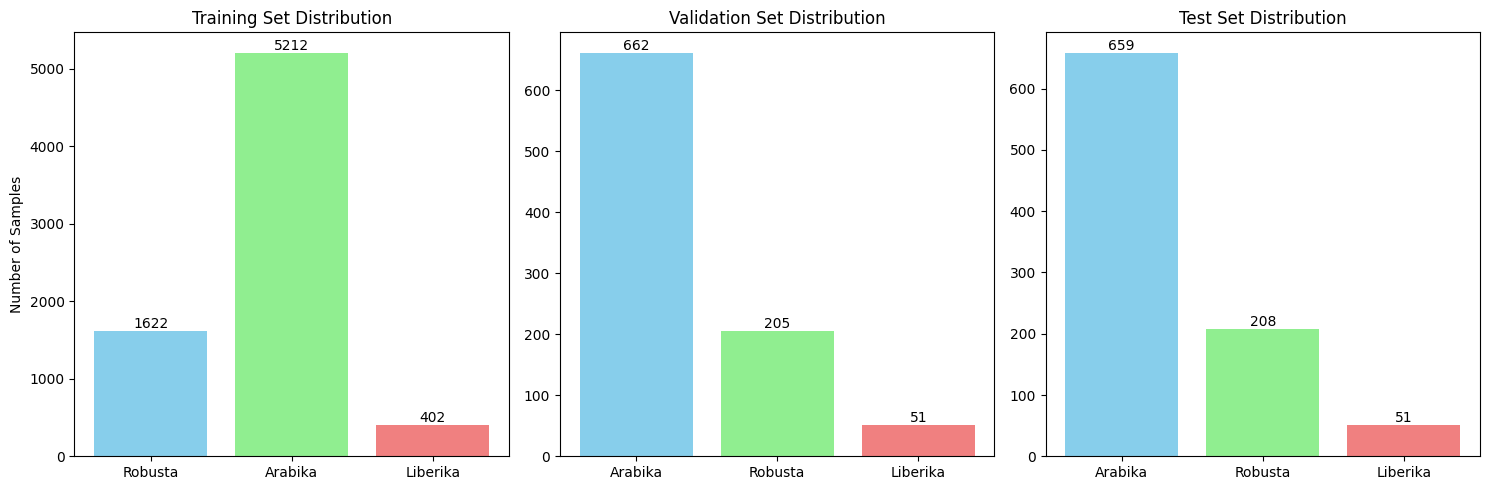

In [7]:
def load_dataset_unbalanced(folder):
    df = pd.read_csv(os.path.join(folder, '_classes.csv'))
    data_per_class = defaultdict(list)

    for _, row in df.iterrows():
        img_path = os.path.join(folder, row['filename'])
        img = cv2.imread(img_path)

        if img is None:
            print(f"Skipping {row['filename']} karena tidak bisa dibaca.")
            continue

        # Langsung gunakan flatten image sebagai fitur (tanpa segmentasi/ekstraksi)
        img_resized = cv2.resize(img, (64, 64))  # Ukuran kecil agar training tidak berat
        feats = img_resized.flatten()

        if feats is not None:
            label_col = row.index[1:]
            label_val = row.iloc[1:]
            label = label_col[label_val == 1].values[0]
            data_per_class[label].append((feats, label))

    # Use all samples without balancing
    X, y = [], []
    for label, samples in data_per_class.items():
        print(f"{label}: {len(samples)} samples (using all)")
        for feat, label in samples:
            X.append(feat)
            y.append(label)

    return np.array(X), np.array(y)

print("Loading unbalanced datasets (tanpa segmentasi/ekstraksi)...")
X_train, y_train = load_dataset_unbalanced("train")
X_valid, y_valid = load_dataset_unbalanced("valid")
X_test, y_test = load_dataset_unbalanced("test")

import collections
print("\nUnbalanced class distribution:")
print("Train:", collections.Counter(y_train))
print("Valid:", collections.Counter(y_valid))
print("Test:", collections.Counter(y_test))

print(f"\nUnbalanced dataset shapes:")
print(f"Train: {X_train.shape}")
print(f"Valid: {X_valid.shape}")
print(f"Test: {X_test.shape}")

# Show class distribution percentages
def print_distribution(y, set_name):
    total = len(y)
    counter = collections.Counter(y)
    print(f"\n{set_name} set distribution:")
    for label, count in counter.items():
        percentage = (count / total) * 100
        print(f"{label}: {count} samples ({percentage:.1f}%)")

print_distribution(y_train, "Training")
print_distribution(y_valid, "Validation")
print_distribution(y_test, "Test")

# Visualize class distribution
plt.figure(figsize=(15, 5))

# Training set distribution
plt.subplot(1, 3, 1)
train_counts = collections.Counter(y_train)
plt.bar(train_counts.keys(), train_counts.values(), color=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Training Set Distribution')
plt.ylabel('Number of Samples')
for i, v in enumerate(train_counts.values()):
    plt.text(i, v, str(v), ha='center', va='bottom')

# Validation set distribution
plt.subplot(1, 3, 2)
valid_counts = collections.Counter(y_valid)
plt.bar(valid_counts.keys(), valid_counts.values(), color=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Validation Set Distribution')
for i, v in enumerate(valid_counts.values()):
    plt.text(i, v, str(v), ha='center', va='bottom')

# Test set distribution
plt.subplot(1, 3, 3)
test_counts = collections.Counter(y_test)
plt.bar(test_counts.keys(), test_counts.values(), color=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Test Set Distribution')
for i, v in enumerate(test_counts.values()):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

cell 5

In [8]:
warnings.filterwarnings('ignore')

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_valid_enc = le.transform(y_valid)
y_test_enc = le.transform(y_test)

# Adjust class weights based on sample distribution
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train_enc), class_weights))

models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=200, 
        max_depth=15, 
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42, 
        class_weight='balanced',
        n_jobs=-1
    ),
    'Extra Trees': ExtraTreesClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ),
    'K-Nearest Neighbors': KNeighborsClassifier(
        n_neighbors=7,
        weights='distance',
        metric='minkowski',
        p=2
    ),
    'Decision Tree': DecisionTreeClassifier(
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        class_weight='balanced'
    ),
    'Gaussian Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(
        C=1.0,
        random_state=42,
        class_weight='balanced',
        max_iter=1000,
        solver='liblinear'
    )
}

results = {}
best_model = None
best_valid_accuracy = 0

print("Training and evaluating multiple models with unbalanced data...")
print("=" * 70)

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    if name != 'Gaussian Naive Bayes':
        pipeline = make_pipeline(StandardScaler(), model)
    else:
        pipeline = model
    
    pipeline.fit(X_train, y_train_enc)
    
    y_valid_pred = pipeline.predict(X_valid)
    valid_accuracy = accuracy_score(y_valid_enc, y_valid_pred)
    
    y_test_pred = pipeline.predict(X_test)
    test_accuracy = accuracy_score(y_test_enc, y_test_pred)
    
    results[name] = {
        'model': pipeline,
        'valid_accuracy': valid_accuracy,
        'test_accuracy': test_accuracy,
        'y_test_pred': y_test_pred
    }
    
    print(f"{name}:")
    print(f"  Validation Accuracy: {valid_accuracy:.4f}")
    print(f"  Test Accuracy: {test_accuracy:.4f}")
    
    if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy
        best_model = name

print("\n" + "=" * 70)
print(f"Best Model: {best_model} with validation Accuracy: {best_valid_accuracy:.4f}")
print("=" * 70)

best_pipeline = results[best_model]['model']
joblib.dump(best_pipeline, "best_coffee_classifier_unbalanced_skenario1.pkl")
joblib.dump(le, "label_encoder_unbalanced_skenario1.pkl")
print(f"\nBest model ({best_model}) saved as 'best_coffee_classifier_unbalanced_skenario1.pkl'")

Training and evaluating multiple models with unbalanced data...

Training Random Forest...
Random Forest:
  Validation Accuracy: 0.8845
  Test Accuracy: 0.8889

Training Extra Trees...
Extra Trees:
  Validation Accuracy: 0.8889
  Test Accuracy: 0.8922

Training K-Nearest Neighbors...
K-Nearest Neighbors:
  Validation Accuracy: 0.8889
  Test Accuracy: 0.8867

Training Decision Tree...
Decision Tree:
  Validation Accuracy: 0.6993
  Test Accuracy: 0.7647

Training Gaussian Naive Bayes...
Gaussian Naive Bayes:
  Validation Accuracy: 0.4325
  Test Accuracy: 0.4248

Training Logistic Regression...
Logistic Regression:
  Validation Accuracy: 0.8715
  Test Accuracy: 0.8508

Best Model: Extra Trees with validation Accuracy: 0.8889

Best model (Extra Trees) saved as 'best_coffee_classifier_unbalanced_skenario1.pkl'


cell 6 buat nampilin hasil training nya

DETAILED RESULTS FOR ALL MODELS

RANDOM FOREST
----------------------------------------
Validation Accuracy: 0.8845
Test Accuracy: 0.8889

Classification Report (Test Set):
              precision    recall  f1-score   support

     Arabika       0.88      0.98      0.93       659
    Liberika       1.00      0.59      0.74        51
     Robusta       0.89      0.68      0.77       208

    accuracy                           0.89       918
   macro avg       0.93      0.75      0.81       918
weighted avg       0.89      0.89      0.88       918


EXTRA TREES
----------------------------------------
Validation Accuracy: 0.8889
Test Accuracy: 0.8922

Classification Report (Test Set):
              precision    recall  f1-score   support

     Arabika       0.89      0.98      0.93       659
    Liberika       0.94      0.57      0.71        51
     Robusta       0.90      0.70      0.79       208

    accuracy                           0.89       918
   macro avg       0.91      0.75  

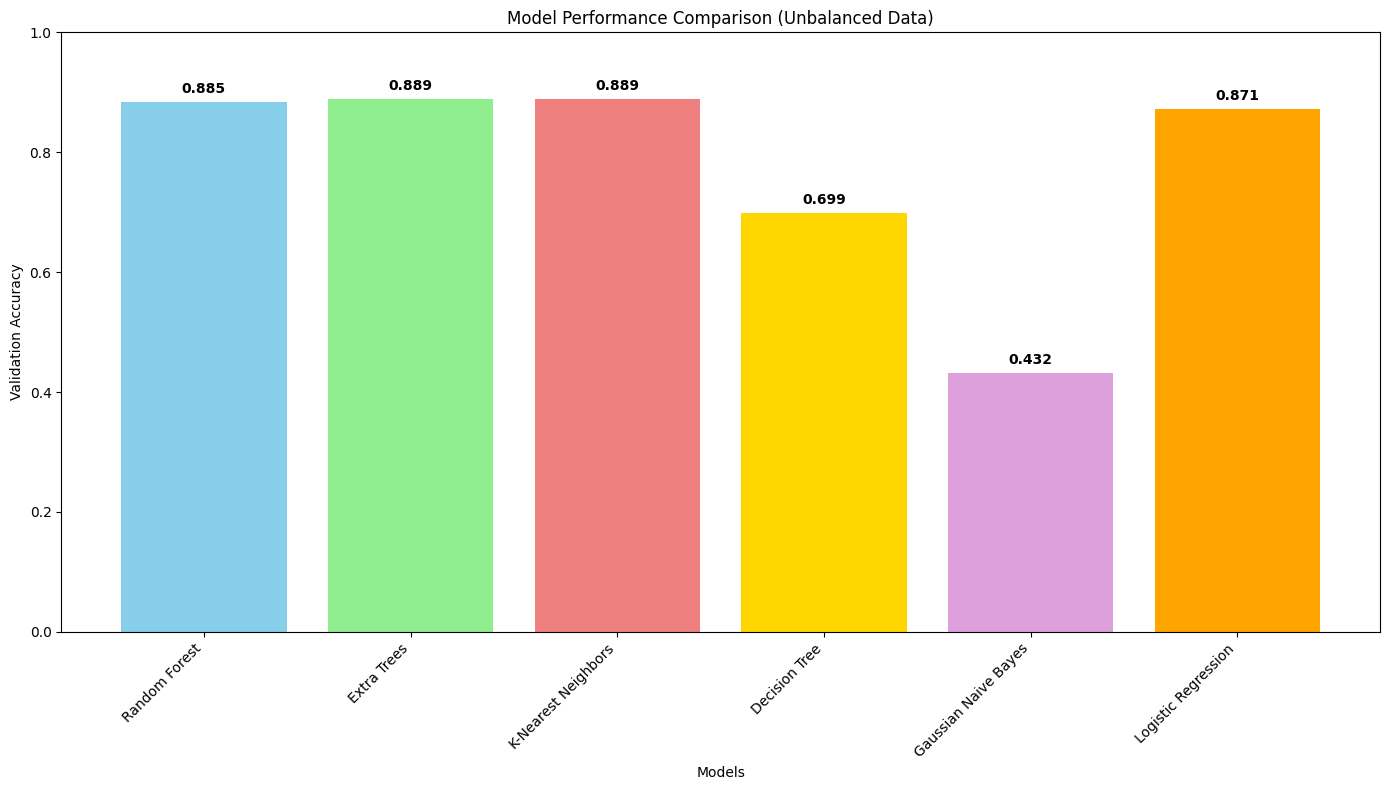


Improvement Analysis:
Best accuracy with unbalanced data: 0.8889


In [9]:
print("DETAILED RESULTS FOR ALL MODELS")
print("=" * 80)

for name, result in results.items():
    print(f"\n{name.upper()}")
    print("-" * 40)
    print(f"Validation Accuracy: {result['valid_accuracy']:.4f}")
    print(f"Test Accuracy: {result['test_accuracy']:.4f}")
    
    print("\nClassification Report (Test Set):")
    print(classification_report(y_test_enc, result['y_test_pred'], target_names=le.classes_))

print("\n" + "=" * 80)
print(f"BEST MODEL: {best_model}")
print("=" * 80)
best_result = results[best_model]
print(classification_report(y_test_enc, best_result['y_test_pred'], target_names=le.classes_))

model_names = list(results.keys())
valid_accuracies = [results[name]['valid_accuracy'] for name in model_names]

plt.figure(figsize=(14, 8))
colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold', 'plum', 'orange']
bars = plt.bar(model_names, valid_accuracies, color=colors[:len(model_names)])
plt.xlabel('Models')
plt.ylabel('Validation Accuracy')
plt.title('Model Performance Comparison (Unbalanced Data)')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)

for bar, acc in zip(bars, valid_accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nImprovement Analysis:")
print(f"Best accuracy with unbalanced data: {best_valid_accuracy:.4f}")

cell 7 save hasil model ama labelnya pake formatnya pkl biar gampang

In [10]:
# #save semua modelnya selain best model
# for name, result in results.items():
#     safe_name = name.replace(' ', '_').replace('(', '').replace(')', '').replace('-', '_')
#     joblib.dump(result['model'], f"coffee_classifier_{safe_name}.pkl")

# print("All models saved:")
# for name in results.keys():
#     safe_name = name.replace(' ', '_').replace('(', '').replace(')', '').replace('-', '_')
#     print(f"- coffee_classifier_{safe_name}.pkl")

# print(f"\nBest model ({best_model}) saved as 'best_coffee_classifier.pkl'")
# print("Label encoder saved as 'label_encoder.pkl'")

cell 8 buat ngecheck tabel evaluasinya

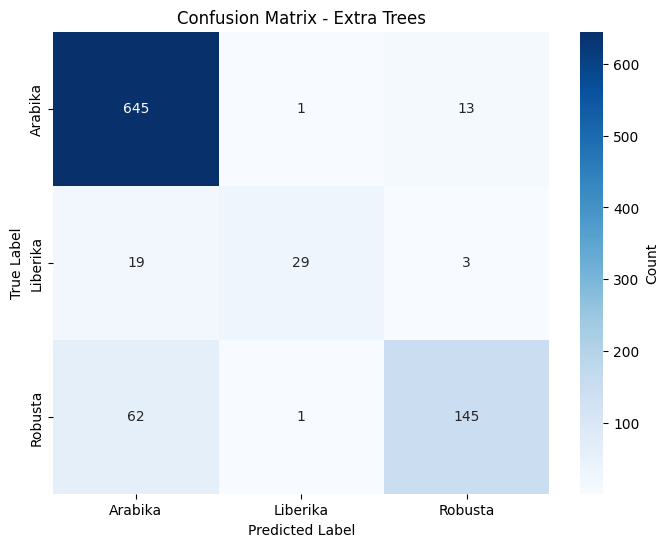

Detailed Evaluation Results:
      Class   TP  FP  FN   TN  Precision  Recall  F1-Score
0   Arabika  645  81  14  178      0.888   0.979     0.931
1  Liberika   29   2  22  865      0.935   0.569     0.707
2   Robusta  145  16  63  694      0.901   0.697     0.786

Overall Accuracy: 0.8922

Best Model: Extra Trees
Test Accuracy: 0.8922


In [11]:
best_pipeline = joblib.load("best_coffee_classifier_unbalanced_skenario1.pkl")
le = joblib.load("label_encoder_unbalanced_skenario1.pkl")

y_test_enc = le.transform(y_test)
y_pred_enc = best_pipeline.predict(X_test)

cm = confusion_matrix(y_test_enc, y_pred_enc)
labels = le.classes_

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, 
            cmap='Blues', cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix - {best_model}')
plt.show()

confusion_table = []

for i, label in enumerate(labels):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    confusion_table.append({
        'Class': label,
        'TP': TP,
        'FP': FP,
        'FN': FN,
        'TN': TN,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

df_confusion = pd.DataFrame(confusion_table)
print("Detailed Evaluation Results:")
print(df_confusion.round(3))

overall_accuracy = accuracy_score(y_test_enc, y_pred_enc)
print(f"\nOverall Accuracy: {overall_accuracy:.4f}")

print(f"\nBest Model: {best_model}")
print(f"Test Accuracy: {overall_accuracy:.4f}")

cell 9 buat testing, testingnya udah di pisahin dan di taro di 3 folder "randomtest*", keluarkan salah satu gambar ke root untuk nge test gambar tersebut

klo mau langsung jalanin testing nya aja menggunakan model .pkl nya, pastiin udah run import libraries nya dulu di cel 1 (paling atas)

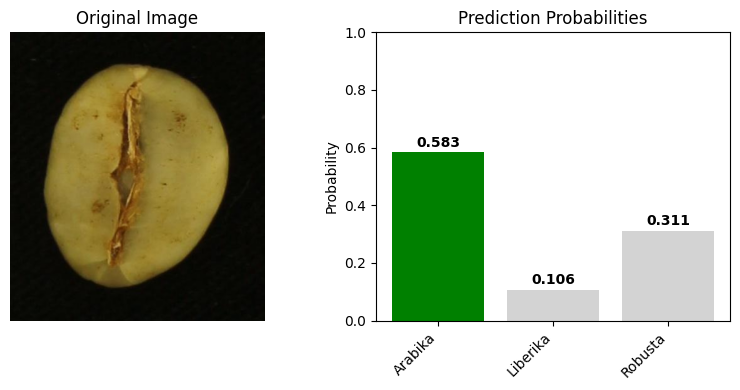

Predicted: Arabika
Probabilities:
  Arabika: 0.583
  Liberika: 0.106
  Robusta: 0.311


In [12]:
best_pipeline = joblib.load("best_coffee_classifier_unbalanced_skenario1.pkl")
le = joblib.load("label_encoder_unbalanced_skenario1.pkl")

def predict_single_image(image_path, pipeline, le):
    img = cv2.imread(image_path)
    if img is None:
        print("Gambar tidak bisa dibaca.")
        return

    feats = extract_features(img)
    if feats is None:
        print("Gagal ekstrak fitur, coba gambar lain.")
        return

    feats = np.array(feats).reshape(1, -1)
    pred_enc = pipeline.predict(feats)
    pred_label = le.inverse_transform(pred_enc)[0]
    
    if hasattr(pipeline, 'predict_proba'):
        proba = pipeline.predict_proba(feats)[0]
        proba_dict = dict(zip(le.classes_, proba))
    else:
        proba_dict = {pred_label: 1.0}

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    classes = list(proba_dict.keys())
    probabilities = list(proba_dict.values())
    colors = ['green' if c == pred_label else 'lightgray' for c in classes]
    bars = plt.bar(classes, probabilities, color=colors)
    plt.title("Prediction Probabilities")
    plt.ylabel("Probability")
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha='right')
    for bar, prob in zip(bars, probabilities):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{prob:.3f}', ha='center', va='bottom', fontweight='bold')
    plt.tight_layout()
    plt.show()

    print(f"Predicted: {pred_label}")
    print("Probabilities:")
    for class_name, prob in proba_dict.items():
        print(f"  {class_name}: {prob:.3f}")

image_paths = glob.glob("coba*.jpg")
if image_paths:
    predict_single_image(image_paths[0], best_pipeline, le)
else:
    print("Tidak ditemukan gambar yang cocok dengan pola 'coba*.jpg'")